<a href="https://colab.research.google.com/github/Manikethan38/Skin-lesion-classification-using-image-classification/blob/main/Skin_lesion_classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project Presentation link : https://drive.google.com/file/d/1T2rQj-qcbV2daAqYQ_X0I9dC4iDM-UB8/view?usp=sharing

## Library

In [ ]:
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116949 sha256=649131166cc5e77c24a0115a59dc18d64fc0d0db3d6b9423e126b5d9ffb75708
  Stored in directory: /root/.cache/pip/wheels/5b/eb/43/7295e71293b218ddfd627f935229bf54af9018add7fbb5aac6
Successfully built fire


In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import medmnist
from medmnist import INFO, Evaluator
import torch
import torchvision

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data

In [ ]:
img=np.load('/content/drive/MyDrive/Adv ML Dataset/dermamnist.npz')

In [ ]:
print(img.keys())

KeysView(<numpy.lib.npyio.NpzFile object at 0x7f8a10b658e0>)


In [ ]:
img.files

['train_images',
 'val_images',
 'test_images',
 'train_labels',
 'val_labels',
 'test_labels']

In [ ]:
train_images=img['train_images']
train_labels=img['train_labels']

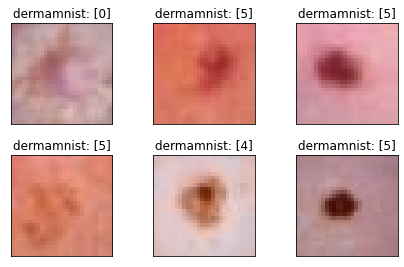

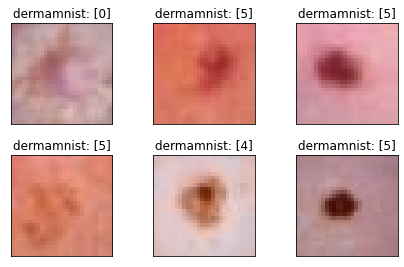

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(train_images[i], cmap='gray', interpolation='none')
  plt.title("dermamnist: {}".format(train_labels[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
train_images.shape

(7007, 28, 28, 3)

In [ ]:
test_images=img['test_images']
test_labels=img['test_labels']

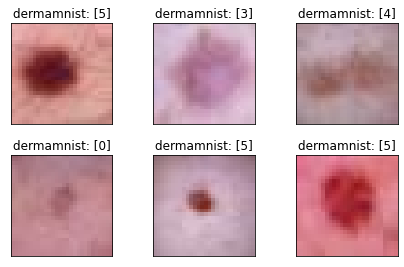

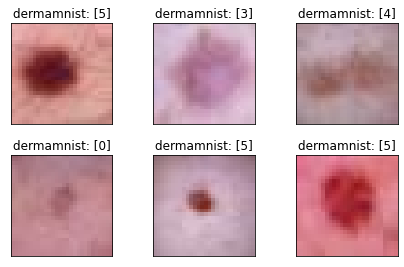

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(test_images[i], cmap='gray', interpolation='none')
  plt.title("dermamnist: {}".format(test_labels[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
img['test_images'].shape

(2005, 28, 28, 3)

## DataLoader

In [ ]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/


In [ ]:
data_flag = 'dermamnist'
download = True # If it is set to false, then data won't be downloaded.

NUM_EPOCHS = 20
BATCH_SIZE = 256
lr = 0.005

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [ ]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.8], std=[.8])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz


In [ ]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset DermaMNIST (dermamnist)
    Number of datapoints: 7007
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY 4.0
Dataset DermaMNIST (dermamnist)
    Number of datapoints: 2005
    Root location: /roo

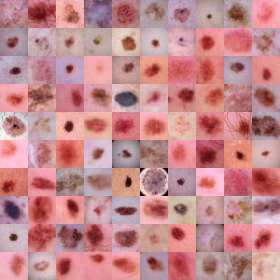

In [ ]:
train_dataset.montage(length=10)

## Building the Network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,256,kernel_size=7)
        self.conv2 = nn.Conv2d(256,50,kernel_size=7)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(200,50)
        self.fc2 = nn.Linear(50,7)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x),2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
        print(x.shape)
        x = x.view(-1,200)
        print(x.shape)
        x = F.relu(self.fc1(x))
        print(x.shape)
        x = F.dropout(x,training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
rand_input = torch.randn(1000,3,28,28)
net = Net()
out = net(rand_input)

torch.Size([1000, 50, 2, 2])
torch.Size([1000, 200])
torch.Size([1000, 50])


<ipython-input-168-8ec305d49438>:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [ ]:
n_epochs = 4
batch_size_train = 128
batch_size_test = 1000
learning_rate = 0.0005
momentum = 0.5
log_interval = 32

random_seed = 56
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    print(target.shape)
    loss = F.cross_entropy(output, target.squeeze())
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      print(target.shape)
      test_loss += F.cross_entropy(output, target.squeeze(), size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
# test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

torch.Size([256, 50, 2, 2])
torch.Size([256, 200])
torch.Size([256, 50])
torch.Size([256, 1])


<ipython-input-168-8ec305d49438>:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/7007 (0%)]	Loss: 1.885430
torch.Size([256, 50, 2, 2])
torch.Size([256, 200])
torch.Size([256, 50])
torch.Size([256, 1])
torch.Size([256, 50, 2, 2])
torch.Size([256, 200])
torch.Size([256, 50])
torch.Size([256, 1])
torch.Size([256, 50, 2, 2])
torch.Size([256, 200])
torch.Size([256, 50])
torch.Size([256, 1])
torch.Size([256, 50, 2, 2])
torch.Size([256, 200])
torch.Size([256, 50])
torch.Size([256, 1])
torch.Size([256, 50, 2, 2])
torch.Size([256, 200])
torch.Size([256, 50])
torch.Size([256, 1])
torch.Size([256, 50, 2, 2])
torch.Size([256, 200])
torch.Size([256, 50])
torch.Size([256, 1])
torch.Size([256, 50, 2, 2])
torch.Size([256, 200])
torch.Size([256, 50])
torch.Size([256, 1])
torch.Size([256, 50, 2, 2])
torch.Size([256, 200])
torch.Size([256, 50])
torch.Size([256, 1])
torch.Size([256, 50, 2, 2])
torch.Size([256, 200])
torch.Size([256, 50])
torch.Size([256, 1])
torch.Size([256, 50, 2, 2])
torch.Size([256, 200])
torch.Size([256, 50])
torch.Size([256, 1])
torch.Size([256,

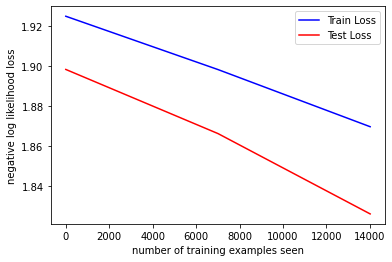

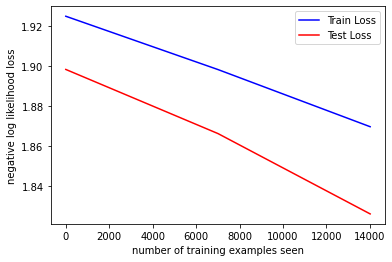

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.plot(test_counter[:-1], test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig